In [1]:
### Notebook for P3D stuff!
import os 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import jax
jax.config.update('jax_platform_name', 'gpu')
from jax.lib import xla_bridge
print("jax version",jax.__version__)
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp

%pylab inline

jax version 0.5.0


/tmp/ipykernel_43549/2213164373.py:10: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


gpu
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jaxpm.kernels import *
#uses jaxpm for some kernels... maybe?

In [3]:
#First things... set the redshift

z= 2.0

#set box geometry, probably should wrap this into the fiducial model file (hdf5?) to lead to less fiddling bugs

bs =  128#box size in Mpc/h
nc =  128#number of pixels per side

mesh_shape = [nc,nc,nc]
box_size = [bs,bs,bs]

ptcl_grid_shape = (nc,) * 3
ptcl_spacing = bs/nc



In [4]:
#some fourier space routines
from helper_functions import *

kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))
#this vector is needed for lots of fourier space transformation operations later on...
print(k.shape)

/tmp/ipykernel_43549/2721841557.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))


(128, 128, 65)


In [5]:
#in this setup, LOS (z) is along the 0 axis, be careful when loading in data!

kz = jnp.ones(k.shape)*kvec[0]**2

kx = jnp.ones(k.shape)*(kvec[1]**2+kvec[2]**2)
#tiny deltas are added to avoid div by zero errors
kk = (kx+kz)+10**(-8)

kpar = kvec[0]
kmu  = jnp.where(k > 0, kpar / k, 0.0)



In [6]:

tau = np.load("/gpfs02/work/diffusion/P3D/data/CROL200_deltaf_bf50_red_zoom150.npy")
from scipy import ndimage
tau_new = ndimage.zoom(tau,128/150)
d_f = tau_new
import powerspectra

In [7]:
k_array, pk = powerspectra.power_spectrum((d_f),kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))

In [8]:
### 3d PS

import numpy as np
import jax
import jax.numpy as jnp
from functools import lru_cache

def _kgrid_and_weights(shape, boxsize):
    """
    Precompute k-vectors on the FFT grid and real-FFT weights W.
    Non-differentiable helper (NumPy), like your _initialize_pk.
    """
    ndim = len(shape)
    # "I" trick from your file to shape k arrays for broadcasting
    I = np.eye(ndim, dtype='int') * -2 + 1

    # Real-FFT symmetry weights (same as your W)
    W = np.empty(shape, dtype=np.float32)
    W[...] = 1.0
    W[(slice(None),)* (ndim-1) + (0,)] = 1.0
    W[(slice(None),)* (ndim-1) + (-1,)] = 1.0

    k = []
    for N, L, kshape, pkshape in zip(shape, boxsize, I, shape):
        ki = np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape)
        k.append(ki)
    k = [jnp.asarray(ki) for ki in k]
    kmag = jnp.sqrt(sum(ki**2 for ki in k))

    return k, kmag, jnp.asarray(W)


def _legendre_vals(mu, ells):
    """
    Evaluate Legendre polynomials L_ell(mu) for multiple ells.
    Uses stable recurrence, JAX-friendly.
    Returns array [n_ell, ...mu.shape]
    """
    mu = jnp.asarray(mu)
    ells = list(ells)
    lmax = max(ells)

    # recurrence
    L0 = jnp.ones_like(mu)
    if lmax == 0:
        Lall = [L0]
    else:
        L1 = mu
        Lall = [L0, L1]
        for l in range(2, lmax + 1):
            Ll = ((2*l - 1) * mu * Lall[-1] - (l - 1) * Lall[-2]) / l
            Lall.append(Ll)

    return jnp.stack([Lall[l] for l in ells], axis=0)


def power_spectrum_multipoles(field, kmin=0.0, dk=0.50, boxsize=None,
                              los=jnp.array([1., 0., 0.]),
                              ells=(0, 2,4),
                              exclude_zero_mode=True):
    """
    Compute anisotropic power spectrum multipoles P_ell(k).

    Args:
        field: real-space field, shape (Nx,Ny,Nz)
        kmin, dk: k-bin settings
        boxsize: array-like length ndim; required
        los: line-of-sight unit vector (ndim,)
        ells: multipoles to compute
        exclude_zero_mode: drop k=0 mode from sums to avoid mu nan

    Returns:
        kbins: (nbin,) bin centers
        P_ells: (n_ell, nbin) multipoles
    """
    if boxsize is None:
        raise ValueError("boxsize must be provided for correct normalization.")

    shape = field.shape
    los = jnp.asarray(los, dtype=jnp.float32)
    los = los / jnp.linalg.norm(los)

    # Precompute grids and weights (NumPy -> JAX arrays)
    kvec, kmag, W = _kgrid_and_weights(shape, jnp.asarray(boxsize))

    # Build mu = khat · los
    kdotn = sum(ki * ni for ki, ni in zip(kvec, los))
    # avoid division by zero at k=0
    mu = jnp.where(kmag > 0, kdotn / kmag, 0.0)

    # k edges / bin ids (still non-diff, like your code)
    kmax = np.pi * np.min(np.array(shape)) / np.max(np.array(boxsize)) + dk / 2
    kedges = np.arange(kmin, kmax, dk)
    dig = np.digitize(np.asarray(kmag).ravel(), kedges)

    # FFT and raw power
    fft_image = jnp.fft.fftn(field)
    pk = real(fft_image * conj(fft_image))

    if exclude_zero_mode:
        # set k=0 contribution to 0 (also avoids mu issues)
        pk = pk.at[(0,)*len(shape)].set(0.0)
        W = W.at[(0,)*len(shape)].set(0.0)

    # flatten mode arrays
    pk_flat = pk.ravel()
    W_flat = W.ravel()
    mu_flat = mu.ravel()

    # Legendre weights per ell per mode
    Lmu = _legendre_vals(mu_flat, ells)  # (n_ell, nmode)

    # Weighted bin sums for each ell:
    # Psum_ell[b] = Σ_modes_in_bin W * pk * L_ell(mu)
    def bin_sum_for_ell(Lmu_ell):
        return jnp.bincount(
            dig,
            weights=W_flat * pk_flat * Lmu_ell,
            length=len(kedges) + 1
        )

    Psum = jax.vmap(bin_sum_for_ell)(Lmu)  # (n_ell, nbins+1)

    # Normalization counts per bin (same for all ells)
    Nsum = jnp.bincount(
        dig,
        weights=W_flat,
        length=len(kedges) + 1
    )

    # Drop under/overflow bins, scale by volume
    vol = jnp.prod(jnp.asarray(boxsize))
    P_ells = (Psum[:, 1:-1] / Nsum[1:-1]) * vol

    # Field normalization, matching your convention
    norm = (np.prod(np.array(shape)).astype('float32')**2)
    P_ells = (P_ells / norm).astype(jnp.float32)

    kbins = jnp.asarray(kedges[:-1] + 0.5 * (kedges[1:] - kedges[:-1]),
                        dtype=jnp.float32)

    return kbins, P_ells


In [9]:
kbins, P_ells = power_spectrum_multipoles((d_f),kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))

/tmp/ipykernel_43549/1335625294.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = jnp.sqrt(sum(ki**2 for ki in k))
/tmp/ipykernel_43549/1335625294.py:87: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kdotn = sum(ki * ni for ki, ni in zip(kvec, los))


In [10]:
P_ells.shape,kbins.shape

((3, 63), (63,))

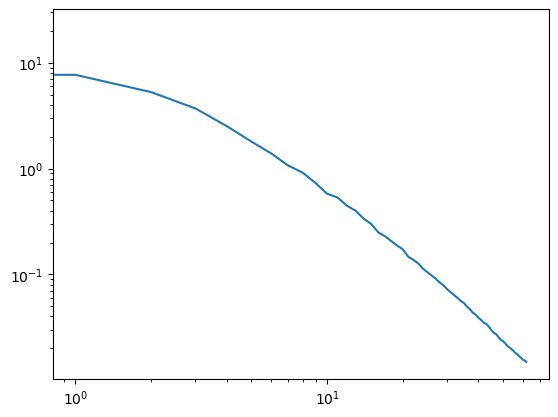

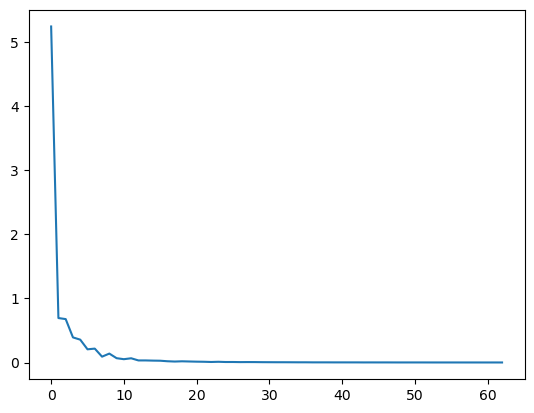

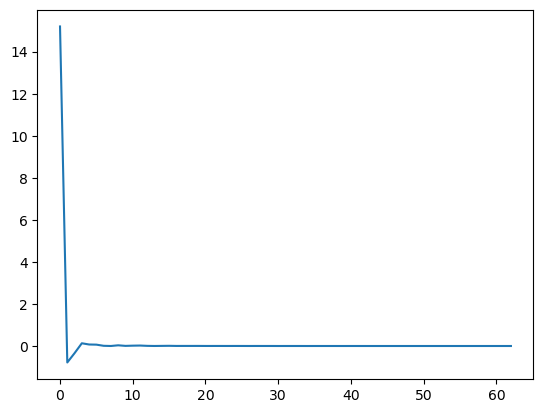

In [11]:
plt.loglog(P_ells[0])
show()
plt.plot(P_ells[1])
show()
plt.plot(P_ells[2])
show()

In [15]:
from scipy import ndimage

In [16]:
#get LOS direction pointed correctly...

df_ani = jnp.swapaxes(d_f,0,-1)#ndimage.gaussian_filter(d_f,[2,0,0])

In [17]:
kbins, P_ells_ani = power_spectrum_multipoles((df_ani),kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))

/tmp/ipykernel_43549/1335625294.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = jnp.sqrt(sum(ki**2 for ki in k))
/tmp/ipykernel_43549/1335625294.py:87: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kdotn = sum(ki * ni for ki, ni in zip(kvec, los))


In [18]:
P_ells_ani.shape

(3, 63)

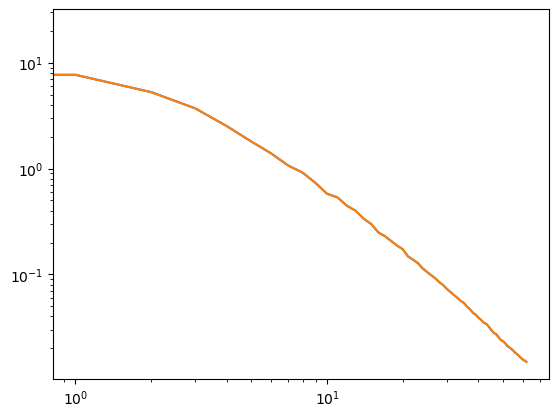

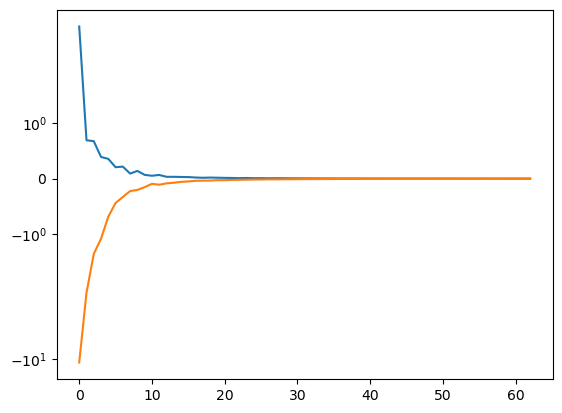

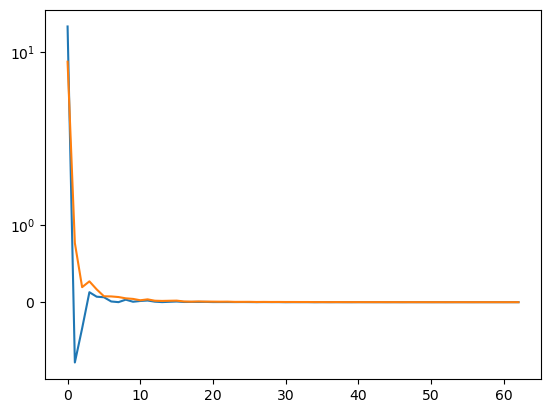

In [19]:
plt.loglog(P_ells[0])
plt.plot(P_ells_ani[0])

show()
plt.plot(P_ells[1])
plt.plot(P_ells_ani[1])
plt.yscale('symlog')

show()
plt.plot(P_ells[2])
plt.plot(P_ells_ani[2])
plt.yscale('symlog')


show()

In [20]:

def legendre_stack(mu, ells):
    """Return L_ell(mu) stacked as (n_ell, ...)."""
    mu = jnp.asarray(mu)
    ells = list(ells)
    lmax = max(ells)

    L0 = jnp.ones_like(mu)
    if lmax == 0:
        Lall = [L0]
    else:
        L1 = mu
        Lall = [L0, L1]
        for l in range(2, lmax + 1):
            Ll = ((2*l - 1) * mu * Lall[-1] - (l - 1) * Lall[-2]) / l
            Lall.append(Ll)
    return jnp.stack([Lall[l] for l in ells], axis=0)

def make_kgrid(shape, boxsize):
    """k-vectors and kmag on rfftn grid (NumPy setup, JAX arrays output)."""
    ndim = len(shape)
    I = np.eye(ndim, dtype='int') * -2 + 1
    kvec = []
    for N, L, kshape, pkshape in zip(shape, boxsize, I, shape):
        ki = np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape)
        kvec.append(jnp.asarray(ki))
    kmag = jnp.sqrt(sum(ki**2 for ki in kvec))
    return kvec, kmag
def transfer_3d_from_multipoles_given_mu(
    theta, k_array, kk, mu_grid,
    ells=(0,2), positive=False
):
    n_ell = len(ells)
    nk = k_array.shape[0]
    theta = theta.reshape(n_ell, nk)

    k3d = jnp.sqrt(kk)

    def interp_one(t_ell):
        return jnp.interp(k3d, k_array, t_ell, left=t_ell[0], right=t_ell[-1])

    T_ell_3d = jax.vmap(interp_one)(theta)

    if positive:
        T_ell_3d = jax.nn.relu(T_ell_3d)

    Lmu = legendre_stack(mu_grid, ells)  # mu_grid is kmu on rfftn grid
    T3d = jnp.sum(T_ell_3d * Lmu, axis=0)
    return T3d

In [21]:
#sampling the tiniest modes doesn't really help very much and makes the optimization much more sensitive
#here we set the modes after 18 to be equal to the fiducial model, could also play around with zeroing them out

#def power_b(theta):#,tff=tff):
#    return transfer_3d_from_multipoles_given_mu(theta, kbins, kk, kmu).reshape(128,128,65)

def power_b_old(theta):
    # theta is flat [P0(k),P2(k),P4(k)] in your convention (tilde P_ell)
    n_ell = 3
    nk = kbins.shape[0]
    theta = theta.reshape(n_ell, nk)
    pref = jnp.array([1, -5, 9])[:, None] / 2  # Calibrate to monopole
    theta_std = (pref * theta).reshape(-1)
    return jax.nn.relu(transfer_3d_from_multipoles_given_mu(theta_std, kbins, kk, kmu).reshape(128,128,65))

def power_b(theta):
    n_ell = 3
    nk = kbins.shape[0]
    theta = theta.reshape(n_ell, nk)

    pref = jnp.array([1, -5, 9])[:, None]
    theta_std = (pref * theta).reshape(-1)

    P3d = transfer_3d_from_multipoles_given_mu(
        theta_std, kbins, kk, kmu, ells=(0,2,4), positive=False
    )

    eps = 1e-3
    return jax.nn.relu(P3d)

In [22]:
#muse componenet...
from functools import partial
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem

In [23]:

#file name
prefix = "V1_DENSE_"
loc = "./configs/"

naa = np.load(loc+prefix+"naa.npy")
kernel = np.load(loc+prefix+"kernel.npy")
skewers_skn = np.load(loc+prefix+"skewers_skn.npy")
skewers_dla = np.load(loc+prefix+"skewers_dla.npy")
skewers_fin = np.load(loc+prefix+"skewers_fin.npy")


from jax import jit
@jit
def cic_readout_jit_jnc(mesh,naa,kernel,bs=False):
    #"highly optimized" CIC, need to preprocess lots of things... don't diff output coords
    meshvals = mesh.flatten()[naa].reshape(-1,8).T#mesh[tuple(neighboor_coords[0,:,:].T.tolist())]
    weightedvals = meshvals.T* kernel[0]
    values = np.sum(weightedvals, axis=-1)
    
    return values



In [84]:
P_ells_ani.shape

(3, 63)

In [25]:
tf_cut_flat = (P_ells_ani*np.array([[1,-1,1]]).T).flatten()

noise_level = 2.0

def gen_map_lya(theta,z):
    modes = z[:nc**3].reshape((nc,nc,nc))    
    Plin = power_b(theta)
    conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
    lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

    lya_values = cic_readout_jit_jnc(lin_modes_real,naa,kernel)
    return lya_values
                 
def gen_map_sim(sim):
    lya_values = cic_readout_jit_jnc(sim,naa,kernel)
    return lya_values
    
class Jax3DMuseProblem_flat(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    #@jax.jit
    def sample_x_z(self, key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nc*nc*nc,))
        x = gen_map_lya(θ,z) + (noise_level*skewers_skn)*jax.random.normal(keys[1], (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
   #     print(z.shape,x.shape)
        return (x, z)

  #  @jax.jit
    def logLike(self, x, z, θ):
        return -(jnp.sum((x - gen_map_lya(θ,z))**2/((noise_level*skewers_skn)**2))+ jnp.sum(z**2.0))

  #  @jax.jit
    def logPrior(self, θ):
        return -jnp.sum(((θ-jnp.array(tf_cut_flat)*1.1)**2 / (2*(tf_cut_flat*0.1)**2)))
    


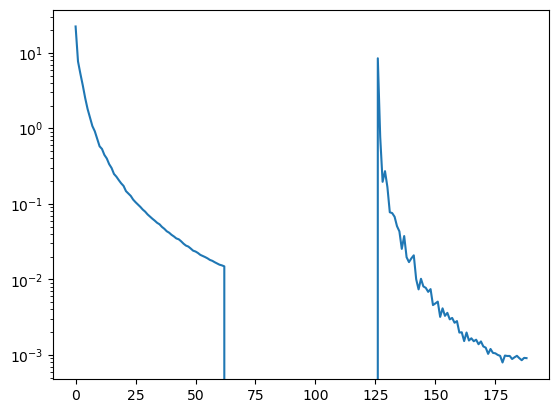

In [26]:
plt.semilogy(P_ells_ani.flatten())

In [63]:
prob = Jax3DMuseProblem_flat(implicit_diff=True,jit=False)
key = jax.random.PRNGKey(30)
if False: #debug
    (x, z) = prob.sample_x_z(key, tf_cut_flat)
    prob.set_x(x)
else:
    z = jax.random.normal(key, (nc*nc*nc,))
   # d_f = np.exp(-1*data)
    siml = gen_map_sim(df_ani) 
    x = siml + (1*skewers_skn)*jax.random.normal(key, (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
    prob.set_x(x)
rng = jax.random.PRNGKey(1)
x_data = x

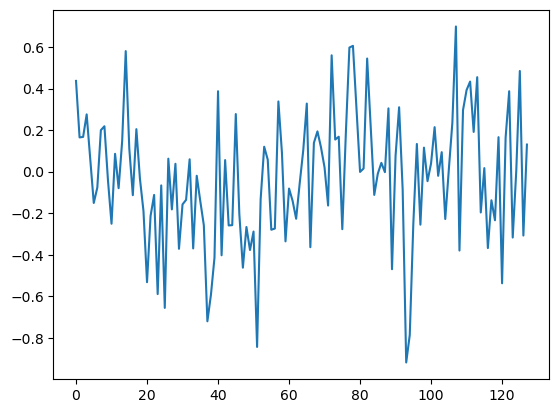

In [64]:
plt.plot(x.reshape(-1,128)[20])

In [65]:
#TT = power_b(P_ells_ani.flatten())
modes = z[:nc**3].reshape((nc,nc,nc))    
Plin = power_b(P_ells_ani.flatten())
conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
lin_modes_real = jnp.fft.irfftn(conv_field)[:,:,:]


In [66]:
modes = z[:nc**3].reshape((nc,nc,nc))
Plin  = power_b(tf_cut_flat.flatten())  # this is P(k,mu)
amp_fac = jnp.sqrt((nc**3) / (bs**3))

conv_field = jnp.fft.rfftn(modes) * (Plin**0.5)
lin_modes_real = jnp.fft.irfftn(conv_field, s=(nc,nc,nc))

In [67]:
amp_fac

Array(1., dtype=float32, weak_type=True)

In [68]:
k_array, pk = powerspectra.power_spectrum((df_ani),kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))
k_arrayl, pkl = powerspectra.power_spectrum(lin_modes_real,kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))


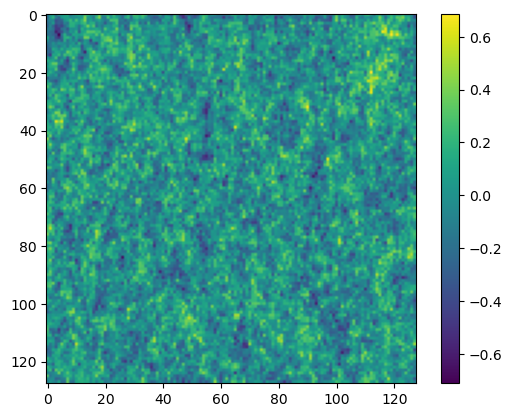

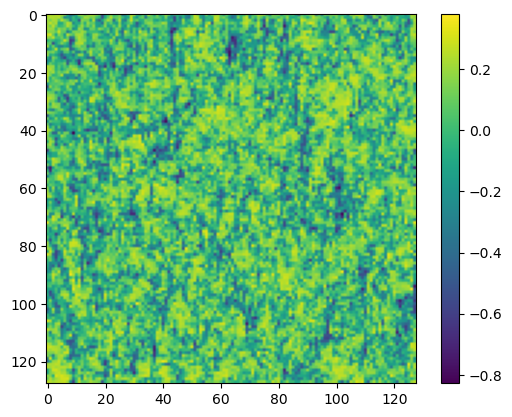

In [85]:
imshow(lin_modes_real[:,:,0])
colorbar()
show()
imshow(df_ani[:,:,0])
colorbar()

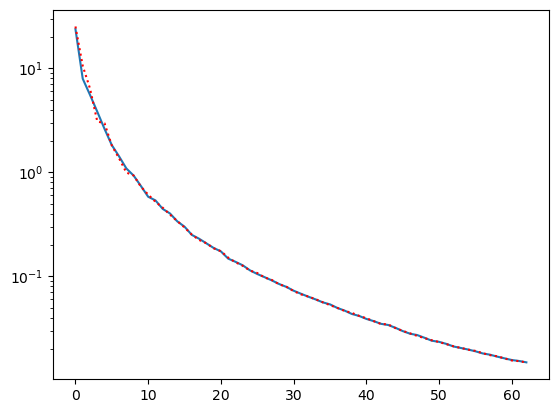

In [86]:
plt.semilogy(pk)
plt.semilogy(pkl,"r:")
show()

In [87]:
kbins2, P_ells_ani = power_spectrum_multipoles((df_ani),kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))

k_arrayl, P_ells_anil = power_spectrum_multipoles(lin_modes_real,kmin=0.001,dk=0.05,boxsize=np.array([128,128,128]))


/tmp/ipykernel_43549/1335625294.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmag = jnp.sqrt(sum(ki**2 for ki in k))
/tmp/ipykernel_43549/1335625294.py:87: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kdotn = sum(ki * ni for ki, ni in zip(kvec, los))


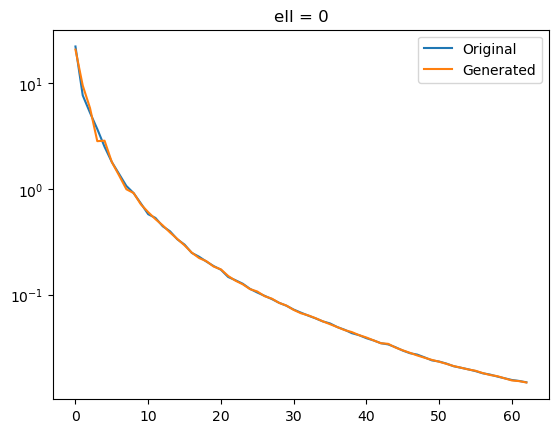

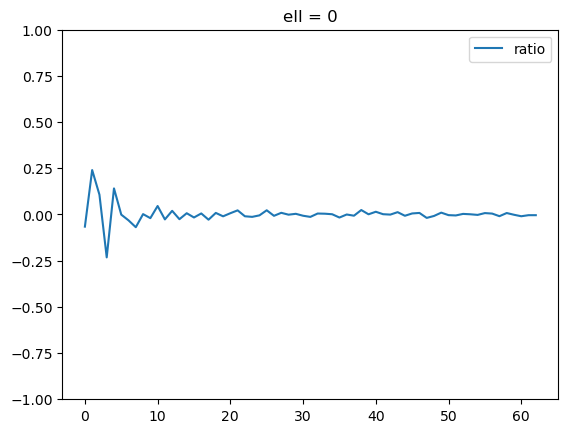

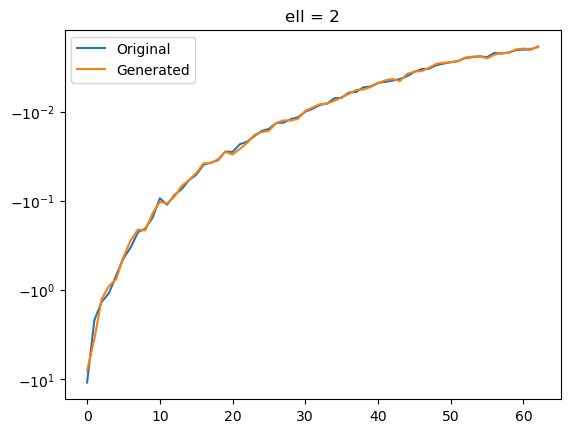

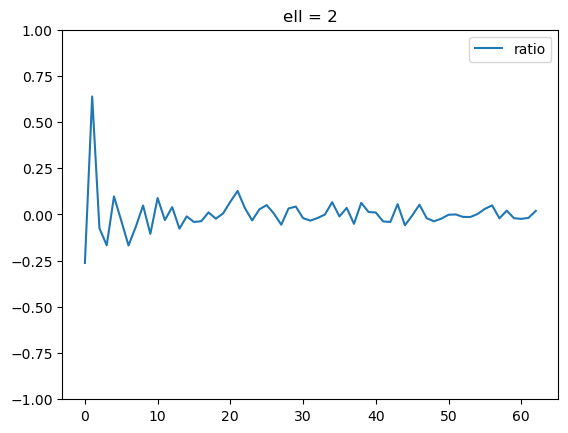

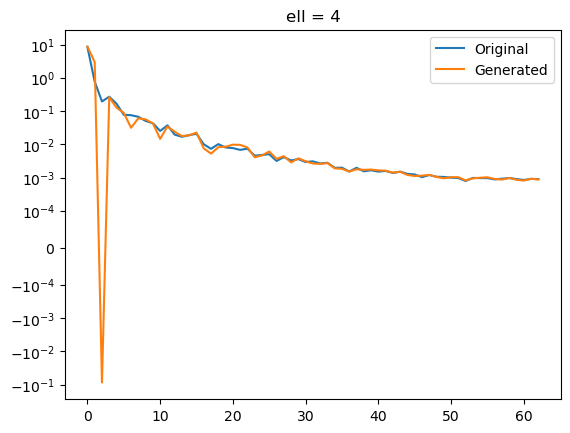

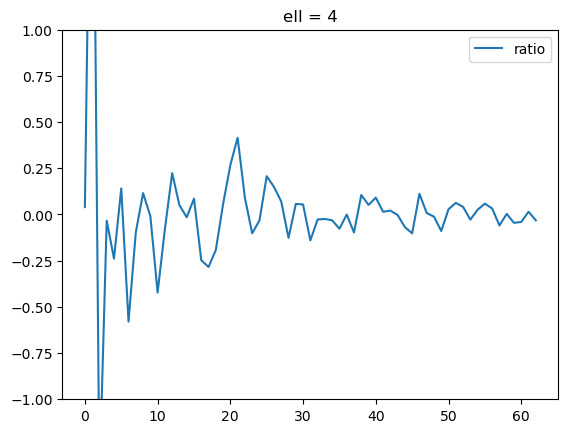

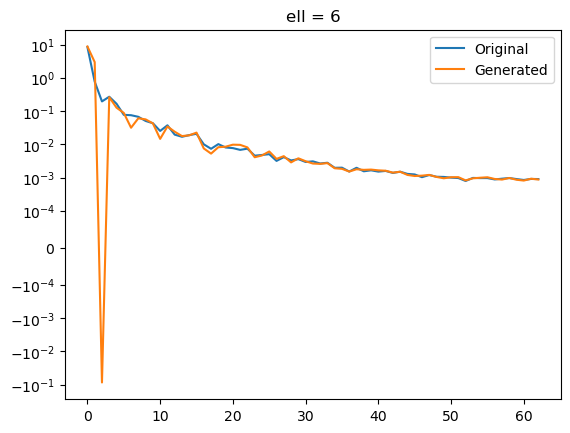

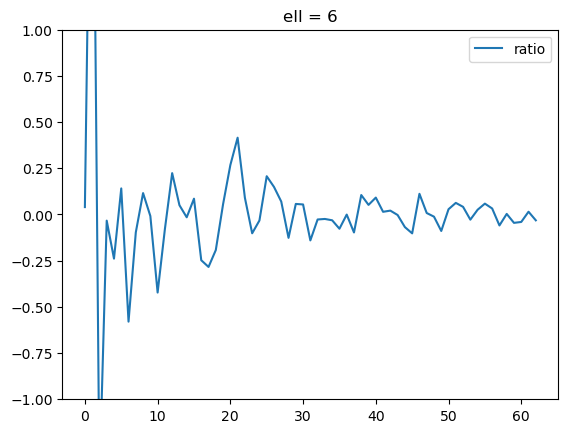

In [88]:

for i in range(0,4):
    plt.plot(P_ells_ani[i],label="Original")
    plt.plot(P_ells_anil[i],label="Generated")
    plt.yscale("symlog",linthresh=1E-4)
    plt.title("ell = " + str(2*i))
    plt.legend()
    plt.savefig("ell_" + str(i*2)+".png")
    plt.savefig("ell_" + str(i*2)+".png")

    plt.show()
    plt.plot((P_ells_anil[i]-P_ells_ani[i])/P_ells_ani[i],label="ratio")
    plt.ylim(-1,1)
    plt.title("ell = " + str(2*i))
    plt.legend()
    #plt.savefig("ell_" + str(i*2)+".png")
    show()

In [89]:
#diagnose_your_forward_model(P_ells_ani, kbins)

In [90]:
#test_multipole_roundtrip()

In [91]:
tf_cut_flat.shape

(189,)

In [92]:
from numpy.random import SeedSequence, default_rng
from copy import copy

start_point = jnp.array(tf_cut_flat)*1.1#+np.random.randn(len(tf_cut_flat))*jnp.array(tf_cut_flat)*0.01)

def _split_rng(rng, N):
    keyz = []
    for i in range(N):
        rng, subkey = jax.random.split(rng)
        keyz.append(rng)
    return keyz
    
θ = start_point

maxsteps = 200
nsims=10
rng = jax.random.PRNGKey(1)

xz_sims = [prob.sample_x_z(_rng, θ) for _rng in _split_rng(rng, nsims)]
xs = [x_data] + [x for (x,_) in xz_sims]
ẑs = [z*0]     + [z*0 for (x, z) in xz_sims]

In [93]:
from jax import grad, hessian, jacfwd, jvp, value_and_grad, vmap

def gradθ_hessθ_logPrior(θ, transformed_θ=None):
        g = grad(prob.logPrior)(θ)
        H = hessian(lambda θ_vec: prob.logPrior(unravel_θ(θ_vec)))(ravel_θ(θ))
        return (g, H)

In [94]:
from datetime import datetime, timedelta
from jax.scipy.optimize import minimize

from multiprocessing.pool import ThreadPool as Pool 
pool = Pool() #jax pmap? check re-compilation times?
pmap = pool.map

#method = 'L-BFGS-B'
method = "l-bfgs-experimental-do-not-rely-on-this"
θ_rtol = 1e-10
z_rtol = 1e-10

θ_tol = 1e-10
z_tol = 1e-10

history = []
α=0.2
beta = 0.25

θ̃ = start_point
θ = start_point# if result.θ is not None else θ_start)
θL = start_point
Nθ = len(ravel_θ(θ̃))
time = timedelta(0)

step: 1 0.1


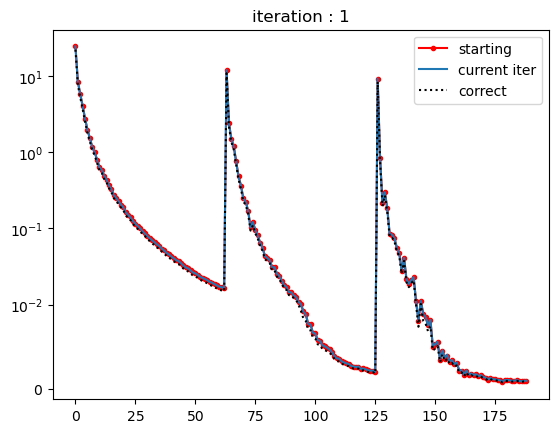

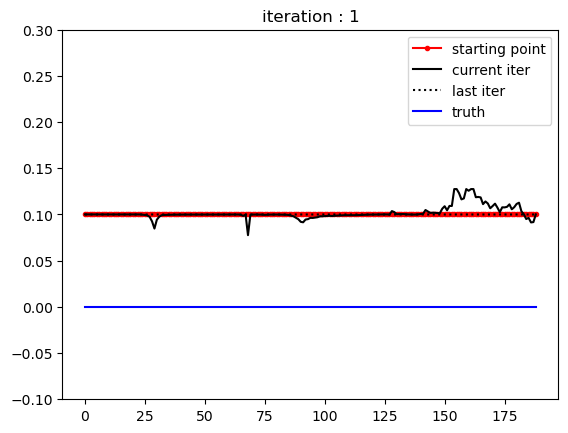

step: 2 0.0975


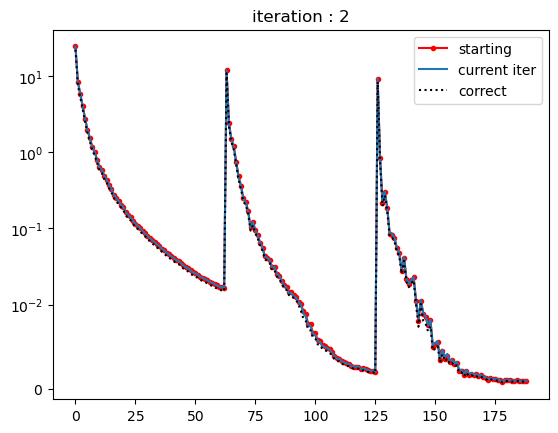

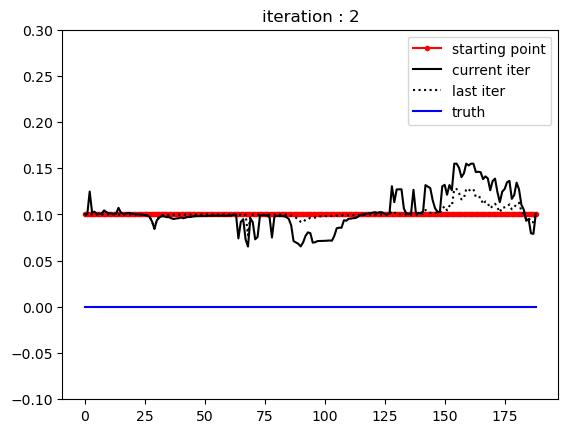

step: 3 0.0950625


In [ ]:
α=0.1

for i in range(1, maxsteps+1):
        print("step:",i,α)
        t0 = datetime.now()

        if i > 1:
            xs = [x_data] + [prob.sample_x_z(_rng, θ)[0] for _rng in _split_rng(rng,nsims)]
            θ_tol = np.sqrt(-np.diag(H̃_inv_post)) * θ_rtol

        if i > 2:
            Δθ̃ = ravel_θ(history[-1]["θ̃"])- ravel_θ(history[-2]["θ̃"])
          #  if np.sqrt(-np.inner(Δθ̃, np.inner(np.linalg.pinv(history[-1]["H̃_inv_post"]), Δθ̃))) < θ_rtol:
           #     break

        # MUSE gradient
        def get_MAPs(x_z):
            x, ẑ_prev = x_z
            result = prob.z_MAP_and_score(x, ẑ_prev, θ, method=method, z_tol=z_tol, θ_tol=θ_tol)
            return result

        MAPs = list(pmap(get_MAPs, zip(xs, ẑs)))

        ẑs = [MAP.z for MAP in MAPs]
   #     if save_MAP_history:
    #        MAP_history_dat, *MAP_history_sims = [MAP.history for MAP in MAPs]
        s_MAP_dat, *s_MAP_sims = [MAP.s for MAP in MAPs]
        s̃_MAP_dat, *s̃_MAP_sims = [MAP.s̃ for MAP in MAPs]
        s̃_MUSE = unravel_θ(ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        s̃_prior, H̃_prior = gradθ_hessθ_logPrior(θ̃, transformed_θ=True)
        s̃_post = unravel_θ(ravel_θ(s̃_MUSE) + ravel_θ(s̃_prior))

        H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
       # try:
        H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        #except:
        #    print("error on Hessian inversion calc, prior ignored and trying again...")
       # H̃_inv_post = H̃_inv_like_sims
        t = datetime.now() - t0
        time += t

        history.append({
            "t":t, "θ̃":θ̃, "θ":θ,
            "s_MAP_dat": s_MAP_dat, "s_MAP_sims": s_MAP_sims,
            "s̃_MAP_dat": s̃_MAP_dat, "s̃_MAP_sims": s̃_MAP_sims, 
            "s̃_MUSE": s̃_MUSE,
            "s̃_prior": s̃_prior, "s̃_post": s̃_post, 
            "H̃_inv_post": H̃_inv_post, "H̃_prior": H̃_prior, 
            "H̃_inv_like_sims": H̃_inv_like_sims,
            "θ_tol": θ_tol,
        #    "MAP_history_dat": MAP_history_dat, 
         #   "MAP_history_sims": MAP_history_sims,
        })
        θ̃update = np.clip((np.inner(H̃_inv_post, ravel_θ(s̃_post))),-ravel_θ(θ̃)*beta,ravel_θ(θ̃)*beta)
        θ̃ = unravel_θ(ravel_θ(θ̃) - α * θ̃update)
        θ = θ̃
        #print(θ)
        if i%1==0:
            plt.plot(start_point,"r.-",label="starting")
            plt.plot(θ,label="current iter")
            plt.plot(tf_cut_flat,"k:",label="correct")
            plt.title("iteration : " + str(i))
            plt.legend()
            plt.yscale("symlog",linthresh=0.01)
            plt.show()
            
            plt.plot((start_point-tf_cut_flat)/tf_cut_flat,"r.-",label="starting point")
            plt.plot((θ-tf_cut_flat)/tf_cut_flat,"k",label="current iter")
            plt.plot((θL-tf_cut_flat)/tf_cut_flat,"k:",label="last iter")
            plt.plot((tf_cut_flat-tf_cut_flat),"b-",label="truth")
            plt.title("iteration : " + str(i))
            plt.legend()

            plt.ylim([-.1,.3])
            plt.show()
            
            θL = θ
            #LR decay
            α *= 0.975

In [ ]:
plt.plot(start_point,"r.-")
plt.plot(θ)
plt.plot(tf_cut_flat,"k:")
plt.yscale("symlog",linthresh=0.01)
plt.show()

In [ ]:
#as you can see, convergence properties are wonky, takes a bit of time to start moving... 
#Should converge if you have the patients to let it run a couple of hours


In [ ]:
#Now lets try to calculate the covariance! :D

In [ ]:
s_MAP_sims = history[-1]["s_MAP_sims"]
_, *z_MAP_sims = ẑs

In [ ]:
def z_MAP_guess_from_truth(x, z, θ):
        return unravel_z(0 * ravel_z(z))
    
nsims = 4
    
def get_J(
        result = None,
        θ = None,
        θ_tol = None,
        z_tol = None,
        method = None,
        rng = None,
        nsims = 10, 
        pmap = map,
        progress = False, 
        skip_errors = False,
    ):

        nsims_remaining = nsims 

        if nsims_remaining > 0:
            print(nsims_remaining)
            t0 = datetime.now()

            def get_s_MAP(rng):
                    (x, z) = prob.sample_x_z(rng, θ)
                    z_MAP_guess = prob.z_MAP_guess_from_truth(x, z, θ)
                    return prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).s
                

            rngs = _split_rng(rng, nsims_remaining)
            s_MAP_sims.extend(s for s in pmap(get_s_MAP, rngs) if s is not None)

#            time += datetime.now() - t0

        J = np.atleast_2d(np.cov(np.stack(list(map(ravel_θ, s_MAP_sims))), rowvar=False))
        return J



In [23]:
J = get_J(rng=rng,θ =θ,method=method, θ_tol=θ_tol, z_tol=z_tol)

10


In [24]:
Hs = []

In [25]:
def pjacobian(f, x, step, pmap=map, pbar=None):
    print(step,x)
    step = step + np.array(0 * x) # make array if scalar

    def column(i):
    
        def v(ε):
            ε_vec = np.array(0 * x)
            ε_vec[i] = ε
            v = f(x + ε_vec)
            if pbar: pbar.update()
            return v

        return (v(step[i]) - v(-step[i])) / (2 * step[i])

    return np.array(list(pmap(column, range(len(x)))))

In [27]:
#This takes a while, roughly an hour or two... Can probably parallelize it across GPUs if you want.

from tqdm import tqdm
from jax.scipy.sparse.linalg import cg

step = None
skip_errors = False
def _get_H_i_old(rng, z_MAP_guess_fid, *, θ, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):
    
    # for each sim, do one fit at fiducial which we'll
    # reuse as a starting point when fudging θ by +/-ϵ
    θfid = θ
    (x, z) = prob.sample_x_z(rng, θfid)
    if z_MAP_guess_fid is None:
        z_MAP_guess = _MAP_guess_from_truth(x, z, θfid)
        z_MAP_guess_fid = z_MAP_and_score(x, z_MAP_guess, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).z

    def get_s_MAP(θvec):
        θ = unravel_θ(θvec)
        (x, _) = prob.sample_x_z(copy(rng), θ)
        return ravel_θ(prob.z_MAP_and_score(x, z_MAP_guess_fid, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).s)

    return pjacobian(get_s_MAP, ravel_θ(θfid), step)


def _get_H_i(rng, z_MAP, *, θ, implicit_diff_cgtol=1e-3, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):

        #implicit implementation..
        cg_kwargs = dict(tol=implicit_diff_cgtol)

        (x, z) = prob.sample_x_z(rng, θ)
        if z_MAP is None:
            z_MAP_guess = z_MAP_guess_from_truth(x, z, θ)
            z_MAP = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).z

        θ_vec, z_MAP_vec = ravel_θ(θ), ravel_z(z_MAP)
        #unravel_θ, unravel_z = unravel_θ, unravel_z

        # non-implicit-diff term
        H1 = jacfwd(
            lambda θ1: grad(
                lambda θ2: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], z_MAP, unravel_θ(θ2))
            )(θ_vec)
        )(θ_vec)

        # term involving dzMAP/dθ via implicit-diff (w/ conjugate-gradient linear solve)
        dFdθ = jacfwd(
            lambda θ: grad(
                lambda z: prob.logLike(x, unravel_z(z), unravel_θ(θ))
            )(z_MAP_vec)
        )(θ_vec)
        dFdθ1 = jacfwd(
            lambda θ1: grad(
                lambda z: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], unravel_z(z), θ)
            )(z_MAP_vec)
        )(θ_vec)
        inv_dFdz_dFdθ1 = vmap(
            lambda vec: cg(
                lambda vec: jvp(lambda z: grad(lambda z: prob.logLike(x, unravel_z(z), θ))(z), (z_MAP_vec,), (vec,))[1], 
                vec, 
                **cg_kwargs
            )[0], 
            in_axes=1, out_axes=1
        )(dFdθ1)
        H2 = -dFdθ.T @ inv_dFdz_dFdθ1
        return H1 + H2

Hs = []

nsims_remaining = nsims  #- len(result.Hs)

z_MAP_sims = z_MAP_sims[:4]

if nsims_remaining > 0:

    # default to finite difference step size of 0.1σ with σ roughly
    # estimated from s_MAP_sims sims, if we have them
    if step is None:
        if len(s_MAP_sims) > 0:
            step = 0.1 / np.std(np.stack(list(map(ravel_θ, s_MAP_sims))), axis=0)
        else:
            step = 1e-5
    
    Nθ = len(ravel_θ(θ))
    pbar = partial(tqdm, total=nsims_remaining, desc="get_H", disable=(True))

    t0 = datetime.now()
    rngs = _split_rng(rng, nsims)[-nsims_remaining:]
    z_MAP_sims = (z_MAP_sims + [None]*(max(0, nsims - len(z_MAP_sims))))[-nsims_remaining:]
    _get_H_ii = partial(_get_H_i, θ=θ, method=method, θ_tol=θ_tol, z_tol=z_tol, step=step, skip_errors=skip_errors)
    Hs.extend(H for H in pbar(map(lambda args: _get_H_ii(*args), zip(rngs, z_MAP_sims)) )if H is not None)
   # result.time += datetime.now() - t0

avg = np.mean#np.median if use_median else np.mean
H = avg(np.array(Hs), axis=0)

In [28]:
Hs[0]

Array([[ 4.20410156e+00,  1.23046875e-01, -8.59878540e-01, ...,
        -1.51703596e-01, -2.16542006e-01,  1.04087591e-02],
       [ 2.88378906e+00,  2.01015625e+01,  1.14453125e+01, ...,
        -1.95632172e+00, -1.69345856e-01,  3.55811119e-02],
       [-1.85821533e-01,  3.92968750e+00,  1.37500000e+02, ...,
         9.35348511e-01,  4.57687378e-01,  1.10086769e-01],
       ...,
       [ 2.62776375e-01, -2.09358215e-01,  3.69171143e-01, ...,
         1.02032500e+04,  1.21103906e+03,  2.10466003e+00],
       [ 6.89918995e-02, -1.89603806e-01, -5.43937683e-02, ...,
         1.21110938e+03,  1.58834375e+03,  4.62094727e+01],
       [-7.46893883e-03, -1.12460852e-02,  2.46706232e-03, ...,
         2.66590881e+00,  4.72617188e+01,  1.86219482e+01]],      dtype=float32)

In [29]:
import scipy as sp

Nθ = len(ravel(θ))

H_prior = -ravel(prob.gradθ_hessθ_logPrior(θ, transformed_θ=False)[1]).reshape(Nθ,Nθ)
Σ_inv = H.T @ np.linalg.pinv(J) @ H + H_prior
Σ = np.linalg.pinv(Σ_inv)
try:
    if θ is not None:
        if Nθ == 1:
            dist = sp.stats.norm(ravel(θ), np.sqrt(Σ[0,0]))
        else:
            dist = sp.stats.multivariate_normal(ravel(θ), Σ)
except:
    print("likely error in covariance... proceed with caution!")

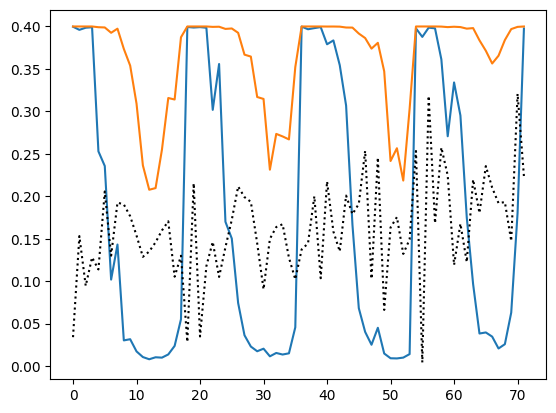

In [30]:
plt.plot(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.sqrt(np.diag(Σ))/tf_cut_flat)

plt.plot(abs((start_point-θ)/tf_cut_flat),"k:")

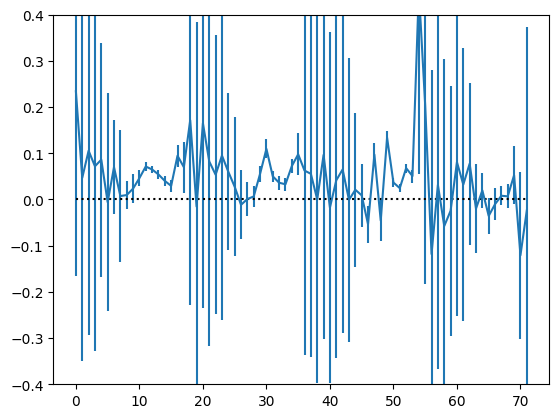

In [33]:
#need to run optimization for longer, since thsoe smaller scale modes in each mu-bin are not converged...
plt.errorbar(np.arange(len(tf_cut_flat)),(θ-tf_cut_flat)/tf_cut_flat,yerr=1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.arange(len(tf_cut_flat)),np.arange(len(tf_cut_flat))*0.0,"k:")
plt.ylim(-0.4,0.4)
plt.show()

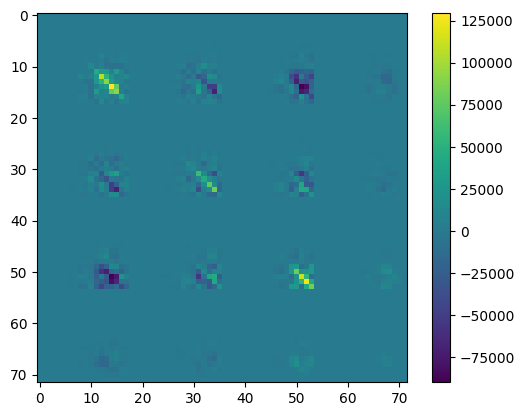

In [34]:
imshow(Σ_inv)
colorbar()

In [ ]:

def test_multipole_roundtrip(nc=128, bs=128):
    """
    Test to determine the correct normalization convention.
    
    Create a simple analytic P(k,mu), extract multipoles, 
    then reconstruct and compare.
    """
    from helper_functions import rfftnfreq_2d
    
    # Setup k-space grid
    ptcl_grid_shape = (nc, nc, nc)
    ptcl_spacing = bs / nc
    kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
    k = jnp.sqrt(sum(ki**2 for ki in kvec))
    
    kpar = kvec[0]
    kmu = jnp.where(k > 0, kpar / k, 0.0)
    kk = sum(ki**2 for ki in kvec) + 1e-8
    
    # Create a simple test case: P(k,mu) = P0(k) * (1 + beta*mu^2)
    # This has only ell=0 and ell=2 components
    P0_k = 100.0 * jnp.exp(-k/0.5)  # Simple exponential
    beta = 0.5
    P_k_mu_true = P0_k * (1.0 + beta * kmu**2)
    
    # Analytical multipoles for P(k,mu) = P0(k) * (1 + beta*mu^2):
    # P0(k) = P0_k * (1 + beta/3)
    # P2(k) = P0_k * (2*beta/3)
    # P4(k) = 0
    P0_analytical = P0_k * (1.0 + beta/3.0)
    P2_analytical = P0_k * (2.0*beta/3.0)
    P4_analytical = jnp.zeros_like(P0_k)
    
    print("=== Testing Analytic Case ===")
    print(f"Test function: P(k,mu) = P0(k) * (1 + {beta}*mu^2)")
    print(f"Expected P0/P0_k = {1 + beta/3:.4f}")
    print(f"Expected P2/P0_k = {2*beta/3:.4f}")
    
    # Generate field with this P(k,mu)
    key = jax.random.PRNGKey(42)
    white_noise = jax.random.normal(key, (nc, nc, nc))
    field_k = jnp.fft.rfftn(white_noise) * jnp.sqrt(P_k_mu_true)
    field_real = jnp.fft.irfftn(field_k, s=(nc, nc, nc))
    
    # Extract multipoles using your function
    kbins, P_ells_extracted = power_spectrum_multipoles(
        field_real,
        kmin=0.01,
        dk=0.1,
        boxsize=jnp.array([bs, bs, bs]),
        ells=(0, 2, 4)
    )
    
    # Bin the analytical multipoles for comparison
    k_flat = k.ravel()
    kedges = np.arange(0.01, np.pi * nc / bs + 0.05, 0.1)
    dig = np.digitize(np.asarray(k_flat), kedges)
    
    def bin_analytical(P_analytical):
        P_flat = P_analytical.ravel()
        Psum = jnp.bincount(dig, weights=P_flat, length=len(kedges)+1)
        Nsum = jnp.bincount(dig, weights=jnp.ones_like(P_flat), length=len(kedges)+1)
        return Psum[1:-1] / Nsum[1:-1]
    
    P0_binned = bin_analytical(P0_analytical)
    P2_binned = bin_analytical(P2_analytical)
    
    # Compare at a mid-range k bin (avoid edges)
    test_bin = len(kbins) // 3
    
    print(f"\n=== At k = {kbins[test_bin]:.3f} h/Mpc ===")
    print(f"Analytical P0 = {P0_binned[test_bin]:.4e}")
    print(f"Extracted  P0 = {P_ells_extracted[0, test_bin]:.4e}")
    print(f"Ratio (extracted/analytical) = {P_ells_extracted[0, test_bin]/P0_binned[test_bin]:.4f}")
    
    print(f"\nAnalytical P2 = {P2_binned[test_bin]:.4e}")
    print(f"Extracted  P2 = {P_ells_extracted[1, test_bin]:.4e}")
    print(f"Ratio (extracted/analytical) = {P_ells_extracted[1, test_bin]/P2_binned[test_bin]:.4f}")
    
    # Now test reconstruction with different prefactor conventions
    print("\n=== Testing Reconstruction ===")
    
    def test_reconstruction_with_prefactor(pref_factor):
        """Test reconstruction with given prefactor."""
        theta = P_ells_extracted.flatten()
        n_ell = 3
        nk = kbins.shape[0]
        theta = theta.reshape(n_ell, nk)
        
        # Apply prefactor
        pref = jnp.array([1, 5, 9])[:, None] * pref_factor
        theta_std = (pref * theta).reshape(-1)
        
        # Reconstruct
        P_reconstructed = transfer_3d_from_multipoles_given_mu(
            theta_std, kbins, kk, kmu, ells=(0,2,4), positive=False
        )
        
        return P_reconstructed
    
    # Test different prefactor options
    prefactors_to_test = {
        "no factor (1.0)": 1.0,
        "with /2 (0.5)": 0.5,
        "with *2 (2.0)": 2.0,
    }
    
    # Sample at center of grid
    i, j, k_idx = nc//2, nc//2, nc//4
    
    print(f"\nAt grid point ({i},{j},{k_idx}):")
    print(f"True P(k,mu) = {P_k_mu_true[i,j,k_idx]:.4e}")
    
    for name, factor in prefactors_to_test.items():
        P_recon = test_reconstruction_with_prefactor(factor)
        print(f"Reconstructed ({name}) = {P_recon[i,j,k_idx]:.4e}, " +
              f"Ratio = {P_recon[i,j,k_idx]/P_k_mu_true[i,j,k_idx]:.4f}")
    
    return kbins, P_ells_extracted, P_k_mu_true


def diagnose_your_forward_model(P_ells_ani, kbins, nc=128, bs=128):
    """
    Diagnose what's happening in your specific case.
    """
    from helper_functions import rfftnfreq_2d
    
    print("\n=== Diagnosing Your Forward Model ===")
    
    # Setup grids
    ptcl_grid_shape = (nc, nc, nc)
    ptcl_spacing = bs / nc
    kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
    k = jnp.sqrt(sum(ki**2 for ki in kvec))
    kpar = kvec[0]
    kmu = jnp.where(k > 0, kpar / k, 0.0)
    kk = sum(ki**2 for ki in kvec) + 1e-8
    
    # Test with multiple random seeds
    n_trials = 20
    ratios_monopole = []
    ratios_quadrupole = []
    
    for seed in range(n_trials):
        key = jax.random.PRNGKey(seed)
        modes = jax.random.normal(key, (nc, nc, nc))
        
        # Generate with your power_b function (test both versions)
        theta_flat = P_ells_ani.flatten()
        n_ell = 3
        nk = kbins.shape[0]
        theta = theta_flat.reshape(n_ell, nk)
        
        # Version WITHOUT /2
        pref_no_div = jnp.array([1, 5, 9])[:, None]
        theta_std_no_div = (pref_no_div * theta).reshape(-1)
        P3d_no_div = transfer_3d_from_multipoles_given_mu(
            theta_std_no_div, kbins, kk, kmu, ells=(0,2,4), positive=False
        )
        
        # Version WITH /2  
        pref_with_div = jnp.array([1, 5, 9])[:, None] / 2.0
        theta_std_with_div = (pref_with_div * theta).reshape(-1)
        P3d_with_div = transfer_3d_from_multipoles_given_mu(
            theta_std_with_div, kbins, kk, kmu, ells=(0,2,4), positive=False
        )
        
        # Generate fields
        field_k_no_div = jnp.fft.rfftn(modes) * jnp.sqrt(jnp.abs(P3d_no_div))
        field_no_div = jnp.fft.irfftn(field_k_no_div, s=(nc, nc, nc))
        
        field_k_with_div = jnp.fft.rfftn(modes) * jnp.sqrt(jnp.abs(P3d_with_div))
        field_with_div = jnp.fft.irfftn(field_k_with_div, s=(nc, nc, nc))
        
        # Extract multipoles
        _, P_ells_no_div = power_spectrum_multipoles(
            field_no_div, kmin=kbins[0]-(kbins[1]-kbins[0])/2, 
            dk=kbins[1]-kbins[0], boxsize=jnp.array([bs, bs, bs])
        )
        
        _, P_ells_with_div = power_spectrum_multipoles(
            field_with_div, kmin=kbins[0]-(kbins[1]-kbins[0])/2,
            dk=kbins[1]-kbins[0], boxsize=jnp.array([bs, bs, bs])
        )
        
        # Compute ratios (avoid first bin due to edge effects)
        ratio_mono_no_div = np.mean(P_ells_no_div[0, 2:10] / P_ells_ani[0, 2:10])
        ratio_mono_with_div = np.mean(P_ells_with_div[0, 2:10] / P_ells_ani[0, 2:10])
        
        ratio_quad_no_div = np.mean(P_ells_no_div[1, 2:10] / P_ells_ani[1, 2:10])
        ratio_quad_with_div = np.mean(P_ells_with_div[1, 2:10] / P_ells_ani[1, 2:10])
        
        ratios_monopole.append((ratio_mono_no_div, ratio_mono_with_div))
        ratios_quadrupole.append((ratio_quad_no_div, ratio_quad_with_div))
    
    ratios_monopole = np.array(ratios_monopole)
    ratios_quadrupole = np.array(ratios_quadrupole)
    
    print(f"\nMonopole (ℓ=0) - averaged over {n_trials} realizations:")
    print(f"  Without /2: mean ratio = {ratios_monopole[:,0].mean():.4f} ± {ratios_monopole[:,0].std():.4f}")
    print(f"  With    /2: mean ratio = {ratios_monopole[:,1].mean():.4f} ± {ratios_monopole[:,1].std():.4f}")
    
    print(f"\nQuadrupole (ℓ=2) - averaged over {n_trials} realizations:")
    print(f"  Without /2: mean ratio = {ratios_quadrupole[:,0].mean():.4f} ± {ratios_quadrupole[:,0].std():.4f}")
    print(f"  With    /2: mean ratio = {ratios_quadrupole[:,1].mean():.4f} ± {ratios_quadrupole[:,1].std():.4f}")
    
    print("\nInterpretation:")
    print("- Ratio ≈ 1.0 means perfect match")
    print("- Ratio > 1.0 means generated field has MORE power")
    print("- Ratio < 1.0 means generated field has LESS power")
    
    if ratios_monopole[:,0].mean() < ratios_monopole[:,1].mean():
        print("\n→ WITHOUT /2 gives closer match (don't use /2)")
    else:
        print("\n→ WITH /2 gives closer match (use /2)")
